In [2]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox


In [3]:
sys.path.append(os.path.join('..', '..', '..' ))

from frameworks.loihi.models.nmnist import augment, NMNISTDataset

In [4]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 34*34*2, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [5]:
import torch
print(torch.version.cuda)         # Should be '11.8'
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # Should say 'NVIDIA GeForce GTX 1070'

11.8
True
NVIDIA GeForce GTX 1070


In [6]:
trained_folder = '../models/Trained'
os.makedirs(trained_folder, exist_ok=True)

# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training_set = NMNISTDataset(path='../../../shared/datasets/NMNIST',train=True, transform=augment)
testing_set  = NMNISTDataset(path='../../../shared/datasets/NMNIST',train=False)

train_loader = DataLoader(dataset=training_set, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=64, shuffle=True, num_workers=6, pin_memory=True)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



NMNIST dataset is freely available here:
https://www.garrickorchard.com/datasets/n-mnist

(c) Creative Commons:
    Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.
    "Converting Static Image Datasets to Spiking Neuromorphic Datasets Using
    Saccades",
    Frontiers in Neuroscience, vol.9, no.437, Oct. 2015



In [7]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

In [8]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [12]:
import os
import torch.profiler

# Ensure the output directory exists
os.makedirs('./profiler_logs', exist_ok=True)

with torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1),
    on_trace_ready=lambda prof: prof.export_chrome_trace('./profiler_logs/profile_trace.pt.trace'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    for i, (input, label) in enumerate(train_loader):
        output = assistant.train(input, label)
        prof.step()
        if i > 10:  # Profile only first 10 batches for speed
            break

print("Profiling complete. Open https://ui.perfetto.dev/ and load profiler_logs/profile_trace.pt.trace to analyze the trace.")

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\torch\profiler\profiler.py:405: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


Profiling complete. Open https://ui.perfetto.dev/ and load profiler_logs/profile_trace.pt.trace to analyze the trace.


In [14]:
epochs = 10

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}", end='\r')
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

[Epoch  9/10] Train loss =     0.25760 (min =     0.26281)     accuracy = 0.95762 (max = 0.95685)  | Test  loss =     0.15762 (min =     0.16126)     accuracy = 0.97700 (max = 0.97460) Epoch 2, Batch 1/938Epoch 3, Batch 1/938Epoch 4, Batch 1/938Epoch 5, Batch 1/938Epoch 6, Batch 1/938Epoch 7, Batch 1/938Epoch 8, Batch 1/938Epoch 9, Batch 1/938Epoch 10, Batch 1/938

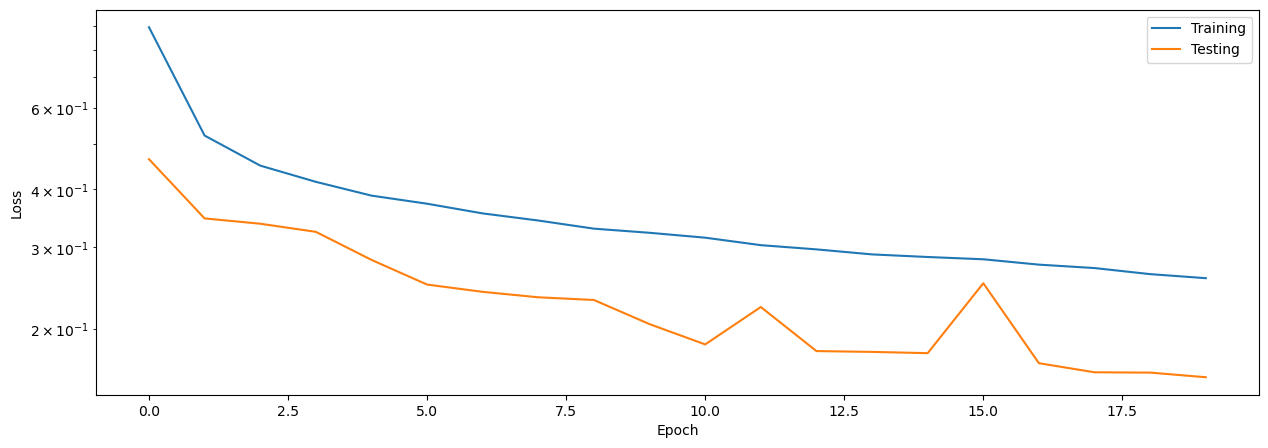

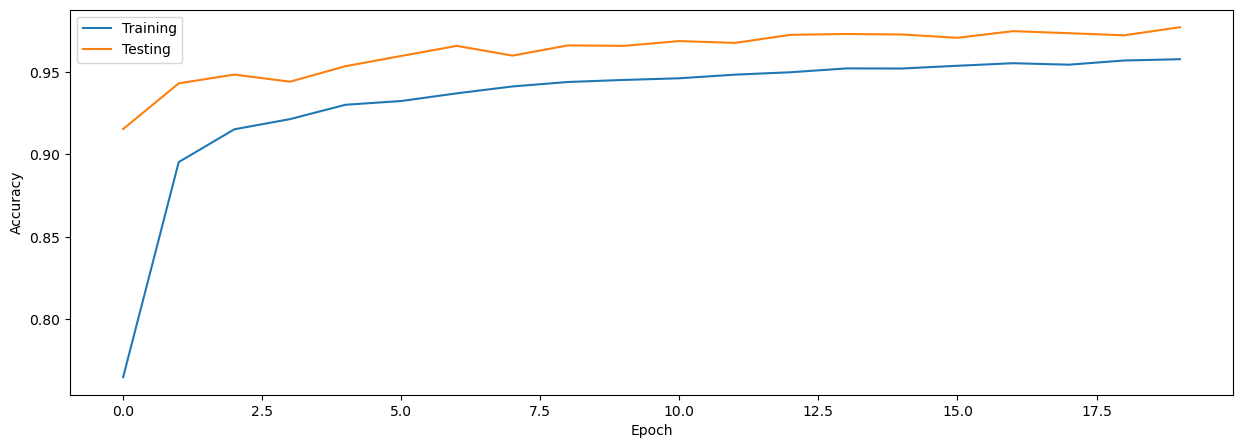

In [15]:
stats.plot(figsize=(15,5))

In [18]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(2, 34, 34, -1))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'../images/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'../images/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [23]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'../images/inp{i}.gif')
    html += gif_td(f'../images/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
